In [3]:
import sys
import pandas as pd
import numpy as np
from os.path import join
from sklearn.linear_model import LassoCV, Lasso, LogisticRegression
import seaborn as sns
from dispersion_ml_model import *

###  1. get train data and test data

In [4]:
z_score_scaler = lambda x: (x-np.mean(x))/(np.std(x))
max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))

In [6]:
train_df = pd.read_csv('files/train_set_info.csv')
test_df = pd.read_csv('files/test_set_info.csv')
test_coin_df = pd.read_csv('files/test_set_coin_info.csv')

In [9]:
len(train_df), len(test_df), len(test_coin_df)

(392, 111, 77)

In [7]:
train_df[['source','machine_type']].value_counts()

source   machine_type
306      SE              319
tiantan  SE               45
         GE               23
         Philips           5
dtype: int64

### 3. select features

In [13]:
all_feats = [one for one in train_df.columns if one.startswith('original_')]
print(len(all_feats))

107


In [16]:
shape_feats = [one for one in all_feats if 'shape' in one]
firstorder_feats = [one for one in all_feats if 'firstorder' in one]
other_feats = [one for one in all_feats if one not in (shape_feats + firstorder_feats)]
print(f'Number of shape features: {len(shape_feats)}')
print(f'Number of firstorder features: {len(firstorder_feats)}')
print(f'Number of other features: {len(other_feats)}')

Number of shape features: 14
Number of firstorder features: 18
Number of other features: 75


In [17]:
train_X = train_df[all_feats]
target_col = 'is_dispersion_all'
train_y = train_df[target_col]

In [18]:
train_X.head()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,0.731953,0.472814,0.516502,0.479894,0.515566,0.525714,0.479846,0.438062,0.266863,0.614838,...,0.388275,0.623128,0.706977,0.077994,0.092748,0.024083,2.590000e-09,0.048593,0.002032,0.001758
1,0.500794,0.476184,0.294710,0.241457,0.175074,0.248050,0.251652,0.210583,0.051092,0.233746,...,0.252517,0.405255,0.720637,0.154163,0.009374,0.007508,8.510000e-09,0.075820,0.003855,0.005826
2,0.775276,0.424474,0.247051,0.220328,0.297454,0.277598,0.169452,0.205229,0.038282,0.319041,...,0.360335,0.578289,0.461319,0.065104,0.015342,0.001205,5.310000e-08,0.016053,0.000217,0.032513
3,0.690066,0.487391,0.381535,0.325269,0.423372,0.303682,0.323991,0.294292,0.111819,0.407903,...,0.193930,0.311231,0.779852,0.057837,0.050930,0.005765,1.110000e-08,0.027438,0.000823,0.006772
4,0.679706,0.499824,0.596374,0.536004,0.561931,0.630631,0.619420,0.572213,0.327486,0.644629,...,0.343000,0.550468,0.813399,0.134222,0.067173,0.069715,8.530000e-10,0.113949,0.010398,0.000629


In [28]:
sub_sel_feats = ['original_shape_LeastAxisLength', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Sphericity', 'original_firstorder_90Percentile', 'original_firstorder_InterquartileRange', 'original_firstorder_Median', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_glcm_ClusterProminence', 'original_glcm_DifferenceVariance', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_LongRunLowGrayLevelEmphasis', 'original_glszm_SizeZoneNonUniformity', 'original_ngtdm_Strength']

In [19]:
# feature filter
# alpha_list = [0.001, 0.002, 0.003, 0.004, 0.005]
alpha_list = [0.002]
for a in alpha_list:
    lasso = Lasso(alpha=a)
    selector = SelectFromModel(lasso).fit(train_X, train_y)
    sel_feats_indexs = selector.get_support(indices=True)
    thre = selector.threshold_
    coefs = selector.estimator_.coef_
    sub_sel_feats = [all_feats[i] for i in sel_feats_indexs]
    sub_sel_coef_feats = [(all_feats[i], coefs[i]) for i in sel_feats_indexs]
    seg_eval_df, _ = compare_model(train_X[sub_sel_feats].values, train_y.values, threshold=0.4)
    print(seg_eval_df)
    print('******************************')

/Users/grace/opt/miniconda3/envs/python37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grace/opt/miniconda3/envs/python37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grace/opt/miniconda3/envs/python37/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as 

[11:57:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:57:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:57:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/grace/opt/miniconda3/envs/python37/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/grace/opt/miniconda3/envs/python37/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/grace/opt/miniconda3/envs/python3

[11:57:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:57:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:57:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

In [20]:
seg_eval_df, seg_mean_tpr_fpr_list = compare_model(train_X[sub_sel_feats].values, train_y.values, threshold=0.4)


/Users/grace/opt/miniconda3/envs/python37/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/grace/opt/miniconda3/envs/python37/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/grace/opt/miniconda3/envs/python3

[11:58:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:58:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:58:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/grace/opt/miniconda3/envs/python37/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/grace/opt/miniconda3/envs/python37/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/grace/opt/miniconda3/envs/python3

[11:58:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:58:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:58:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

In [53]:
seg_eval_df

,model_name,acc,recall,precision,auc
0,LR,0.864936,0.825773,0.842471,0.930969
1,SVM,0.872372,0.817725,0.848114,0.933719
2,Decision Tree,0.755321,0.551699,0.583279,0.806594
3,KNN,0.798269,0.552918,0.890577,0.881246
4,Random Forest,0.844679,0.742564,0.851122,0.905181
5,Adaboost,0.852179,0.786564,0.812206,0.915614
6,GBDT,0.857372,0.798776,0.819127,0.928553
7,Xgboost,0.859423,0.811052,0.837056,0.919967
8,Ensemble,0.867115,0.832411,0.831919,0.930335


In [67]:
def draw_roc(mean_tpr_fpr_list, save_path=None):
    fig, ax = plt.subplots()
    for item in seg_mean_tpr_fpr_list:
        model_name = item['model_name']
        mean_fpr, mean_tpr, mean_auc, std_auc = item['items']
        ax.plot(mean_fpr, mean_tpr, label=r'%s (AUC = %0.2f $\pm$ %0.2f)' % (model_name, mean_auc, std_auc), lw=2, alpha=0.8)
    cl_x = range(-2, 2)
    cl_y = range(-2, 2)
    ax.plot(cl_x, cl_y, color='gray', alpha=0.5, linestyle='--', linewidth=0.7)
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title='Mean ROC Curve(10-fold cross validation)')
    ax.legend(loc='lower right')
    plt.ylabel('True Positive')
    plt.xlabel('False Positive')
    if save_path is not None:
#         plt.legend(prop={'family': 'Times New Roman', 'size':1})
        plt.savefig(save_path, dpi=300)
    plt.show()

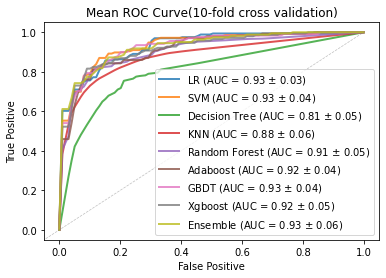

In [68]:
draw_roc(seg_mean_tpr_fpr_list)

### Train by ensemble model

In [33]:
from sklearn.ensemble import VotingClassifier

xgb = XGBClassifier(learning_rate=0.1, n_estimators=70, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective='binary:logistic', nthred=4, scale_pos_weight=1, seed=27)
lr = LogisticRegression(C=1)
svm_model = svm.SVC(kernel='linear', C=1, probability=True)
rf_model = RandomForestClassifier(n_estimators=10)
adb_model = AdaBoostClassifier(n_estimators=100, learning_rate=0.1)
gbdt_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_depth=2, min_samples_split=8)



In [34]:
eclf = VotingClassifier(estimators=[('lr', lr), ('rf', rf_model), ('svm', svm_model), ('adb', adb_model), ('gbdt', gbdt_model)], voting='soft',flatten_transform=False)

In [35]:
train_df[['source', 'machine_type']].value_counts()

source   machine_type
306      SE              319
tiantan  SE               45
         GE               23
         Philips           5
dtype: int64

In [36]:
test_df[['source', 'machine_type']].value_counts()

source   machine_type
306      SE              67
tiantan  SE              27
         GE              12
         Philips          5
dtype: int64

In [37]:
print(len(sub_sel_feats))
eclf.fit(train_X[sub_sel_feats].values, train_y.values)

14


VotingClassifier(estimators=[('lr', LogisticRegression(C=1)),
                             ('rf', RandomForestClassifier(n_estimators=10)),
                             ('svm',
                              SVC(C=1, kernel='linear', probability=True)),
                             ('adb',
                              AdaBoostClassifier(learning_rate=0.1,
                                                 n_estimators=100)),
                             ('gbdt',
                              GradientBoostingClassifier(max_depth=2,
                                                         min_samples_split=8,
                                                         n_estimators=60))],
                 flatten_transform=False, voting='soft')

In [38]:
def evaluation(y_true, y_pred_proba, model_name, data_set_name, threshold=0.5):
    if not isinstance(y_true, list):
        y_true = y_true.tolist()
    y_pred = np.where(y_pred_proba > threshold, 1, 0)
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    dic = {'model_name':model_name, 'acc':acc, 'recall':recall, 'precision':precision, 'auc':auc_score}
    return dic

In [71]:
y_pred_train = eclf.predict_proba(train_X[sub_sel_feats].values)[:,1]
train_eval_dic = evaluation(train_y.values, y_pred_train, 'ensemble_train', 'train', 0.4)
print(train_eval_dic)

{'model_name': 'ensemble_train', 'acc': 0.9285714285714286, 'recall': 0.9261744966442953, 'precision': 0.8903225806451613, 'auc': 0.9847543292733449}


In [72]:
test_X = test_df[all_feats]
target_col = 'is_dispersion_all'
test_y = test_df[target_col]

In [73]:
test_X.head()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
1,0.731797,0.482442,0.551429,0.507217,0.617245,0.544672,0.461517,0.524590,0.283301,0.647619,...,0.368741,0.574380,0.776980,0.276552,0.027869,0.174640,3.028994e-10,0.321818,0.074841,0.000265
8,0.395757,0.504105,0.493448,0.427127,0.358304,0.435070,0.286293,0.373617,0.153608,0.347624,...,0.317516,0.501363,0.833328,0.268116,0.015351,0.114054,5.134671e-10,0.379012,0.121540,0.000407
20,0.572672,0.600635,0.464033,0.328818,0.410523,0.268363,0.389740,0.342007,0.104998,0.353252,...,0.238143,0.382187,0.670733,0.059111,0.046738,0.007647,8.335987e-09,0.038616,0.001645,0.005242
26,0.853534,0.716603,0.404946,0.221279,0.270095,0.271587,0.287024,0.243352,0.077265,0.350388,...,0.360387,0.578371,0.678984,0.109406,0.019472,0.008102,7.881136e-09,0.054986,0.003357,0.004770
27,0.426239,0.332082,0.421595,0.528203,0.540071,0.546670,0.333005,0.477632,0.116816,0.454657,...,0.320248,0.513954,0.777841,0.254314,0.012524,0.053858,1.160287e-09,0.236355,0.067325,0.000771


In [74]:
# test中完全一致的数据
test_X1 = test_coin_df[all_feats]
test_y1 = test_coin_df[target_col]


77


In [75]:
y_pred_test = eclf.predict_proba(test_X[sub_sel_feats].values)[:,1]
test_eval_dic = evaluation(test_y.values, y_pred_test, 'ensemble_test', 'test', 0.4)
print(test_eval_dic)

{'model_name': 'ensemble_test', 'acc': 0.9009009009009009, 'recall': 0.8387096774193549, 'precision': 0.8125, 'auc': 0.9520161290322582}


In [76]:
y_pred_test1 = eclf.predict_proba(test_X1[sub_sel_feats].values)[:,1]
# print(y_pred_test1.shape)
test_eval_dic1 = evaluation(test_y1.values, y_pred_test1, 'ensemble_test1', 'test1', 0.4)
print(test_eval_dic1)

{'model_name': 'ensemble_test1', 'acc': 0.948051948051948, 'recall': 0.9411764705882353, 'precision': 0.8421052631578947, 'auc': 0.988235294117647}


In [78]:
res_df = pd.DataFrame([train_eval_dic,test_eval_dic,test_eval_dic1])

In [79]:
res_df

,model_name,acc,recall,precision,auc
0,ensemble_train,0.928571,0.926174,0.890323,0.984754
1,ensemble_test,0.900901,0.838710,0.812500,0.952016
2,ensemble_test1,0.948052,0.941176,0.842105,0.988235
